# Estudo de Preços e Combustíveis

Usando Cassandra, Python e Jupyter Notebook

In [1]:
cassandra_ports = ['192.168.99.100']

### Declaração de classses de dados

In [2]:
class Vendas():
    def __init__(self, regiao, estado, municipio, revenda, 
                 produto, dt_coleta, valor_compra, 
                 valor_venda, unidade_medida, bandeira):
        self.regiao = regiao
        self.estado = estado
        self.municipio = municipio
        self.revenda = revenda
        self.produto = produto
        self.dt_coleta = dt_coleta
        self.mes = int(dt_coleta[3:5])
        self.ano = int(dt_coleta[6:10])

        self.valor_compra = None
        if (valor_compra != ''):
            self.valor_compra = float(valor_compra.replace(',', '.'))

        self.valor_venda = None
        if (valor_venda != ''):
            self.valor_venda = float(valor_venda.replace(',', '.'))
        
        self.unidade_medida = unidade_medida
        self.bandeira = bandeira

    def get_regiao(self):
        return self.regiao

    def get_estado(self):
        return self.estado

    def get_municipio(self):
        return self.municipio

    def get_revenda(self):
        return self.revenda

    def get_produto(self):
        return self.produto    
        
    def get_dt_coleta(self):
        return self.dt_coleta
    
    def get_mes(self):
        return self.mes
    
    def get_ano(self):
        return self.ano
    
    def get_valor_compra(self):
        return self.valor_compra
    
    def get_valor_venda(self):
        return self.valor_venda
    
    def get_unidade_medida(self):
        return self.unidade_medida        
    
    def get_bandeira(self):
        return self.bandeira     

In [3]:
class Vendas_Valor():
    def __init__(self, municipio, bandeira, revenda, produto, dt_coleta, valor_venda):
        self.municipio = municipio
        self.bandeira = bandeira
        self.revenda = revenda
        self.produto = produto
        self.dt_coleta = dt_coleta
        self.valor_venda = valor_venda 
        self.mes = int(dt_coleta[3:5])
        self.ano = int(dt_coleta[6:10])
            
    def get_municipio(self):
        return self.municipio
    
    def get_bandeira(self):
        return self.bandeira
    
    def get_revenda(self):
        return self.revenda    
    
    def get_produto(self):
        return self.produto    

    def get_dt_coleta(self):
        return self.dt_coleta
    
    def get_valor_venda(self):
        return self.valor_venda    
    
    def get_mes(self):
        return self.mes    
    
    def get_ano(self):
        return self.ano    

In [4]:
class Dolares_Mes():
    def __init__(self, ano, mes, valor_compra):
        self.ano = ano
        self.mes = mes
        self.valor_compra = valor_compra

    def get_ano(self):
        return self.ano
    
    def get_mes(self):
        return self.mes
    
    def get_valor_compra(self):
        return self.valor_compra

In [5]:
class Combustivel_Mes():
    def __init__(self, ano, mes, produto, valor_venda, qtd):
        self.ano = ano
        self.mes = mes
        self.produto = produto
        self.valor_venda = valor_venda
        self.qtd = qtd

    def get_ano(self):
        return self.ano
    
    def get_mes(self):
        return self.mes
    
    def get_produto(self):
        return self.produto
    
    def get_valor_venda(self):
        return self.valor_venda
    
    def get_qtd(self):
        return self.qtd   

In [6]:
class Media_Mes():
    def __init__(self, ano, mes, dolar, diesel, diesel_s10, etanol, gasolina, gnv):
        self.ano = ano
        self.mes = mes
        self.dolar = dolar
        self.diesel = diesel
        self.diesel_s10 = diesel_s10        
        self.etanol = etanol
        self.gasolina = gasolina        
        self.gnv = gnv        
    
    def get_ano(self):
        return self.ano
    
    def get_mes(self):
        return self.mes
    
    def get_dolar(self):
        return self.dolar
    
    def get_diesel(self):
        return self.diesel
    
    def get_diesel_s10(self):
        return self.diesel_s10
    
    def get_etanol(self):
        return self.etanol
    
    def get_gasolina(self):
        return self.gasolina
    
    def get_gnv(self):
        return self.gnv    

### Declaração de conexões e carregadores de dados

In [7]:
def load_vendas_info_file(fname):
    vendas = []
    with open(fname, encoding="latin-1") as f:
        next(f)
        for line in f: 
            vendas.append(Vendas(*str(line).strip().split('\t')))
    f.close()
    return vendas

Inslalar o Driver Cassandra caso já não esteja instalado

```shell
pip install cassandra-driver
```

In [8]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

CASSANDRA_USER = 'cassandra'
CASSANDRA_PASSWD = 'password'

def create_connection(nodeIP, keyspaceName):
    client = Connection()
    client.connect(nodeIP) #Observar que o nodeIP é uma lista e não somente um único valor
    client.set_keyspace(keyspaceName)
    return client

class Connection:
    session = None
    keyspace = ""

    def connect(self, nodes):
        auth_provider = PlainTextAuthProvider(username=str(CASSANDRA_USER), password=str(CASSANDRA_PASSWD))
        cluster = Cluster(nodes, auth_provider=auth_provider)
        metadata = cluster.metadata
        self.session = cluster.connect()

    def get_session():
        return self.session

    def set_keyspace(self, keyspace):
        self.keyspace = keyspace

    def get_keyspace(self):
        return self.keyspace

    def close(self):
        self.session.cluster.shutdown()
        self.session.shutdown()

    def query_schema(self, table):
        table_keyspace = self.keyspace+"."+table
        query = " SELECT * FROM "+ table_keyspace +";"
        result_set = self.session.execute(query)
        return result_set

In [9]:
#Classe pai das conexões
class CommonCassandraDB():

    def __init__(self):
        self.cassandra_table_reference = None
        self.client = None

    def set_cassandra_client(self, nodeIP, keyspaceName):
        self.client = create_connection(nodeIP, keyspaceName)

    def close_connection(self):
        self.client.close()

### Declaração de classes com conexões

In [10]:
class VendasValorCassandra(CommonCassandraDB):
    
    def __init__(self, nodeIP, keyspace):
        self.cassandra_table_reference = 'vendas_valor' #nome da Tabela do Cassandra
        self.set_cassandra_client(nodeIP, keyspace)
   
    def get_object_list(self, list):
        objects = []
        for item in list:
            objects.append(Vendas_Valor(
                item.municipio, 
                item.bandeira, 
                item.revenda,
                item.produto, 
                item.dt_coleta, 
                item.valor_venda
            ))
        return objects

    def get_full_table(self):
        table = self.client.get_keyspace() + "." + self.cassandra_table_reference
        sql_query = 'SELECT * FROM @$$$$$$$$$$$$@'.replace("@$$$$$$$$$$$$@", table)
        list = self.client.session.execute(sql_query)
        return self.get_object_list(list)
    
    def get_mais_caros(self, municipio, produto, limite):
        table = self.client.get_keyspace() + "." + self.cassandra_table_reference
        sql_query = """
            SELECT *
            FROM @TABELA
            WHERE municipio = '@MUNICIPIO'
            AND produto = '@PRODUTO'
            ORDER BY valor_venda DESC
            LIMIT @LIMITE
            """
        sql_query = sql_query.replace("@TABELA", table)
        sql_query = sql_query.replace("@MUNICIPIO", municipio)
        sql_query = sql_query.replace("@PRODUTO", produto)
        sql_query = sql_query.replace("@LIMITE", str(limite))
        
        list = self.client.session.execute(sql_query)
        return self.get_object_list(list)
    
    def get_mais_baratos(self, municipio, produto, limite):
        table = self.client.get_keyspace() + "." + self.cassandra_table_reference
        sql_query = """
            SELECT *
            FROM @TABELA
            WHERE municipio = '@MUNICIPIO'
            AND produto = '@PRODUTO'
            ORDER BY valor_venda
            LIMIT @LIMITE
            """
        sql_query = sql_query.replace("@TABELA", table)
        sql_query = sql_query.replace("@MUNICIPIO", municipio)
        sql_query = sql_query.replace("@PRODUTO", produto)
        sql_query = sql_query.replace("@LIMITE", str(limite))
        
        list = self.client.session.execute(sql_query)
        return self.get_object_list(list)
    
    def get_municipio_produto(self, municipio, produto):
        table = self.client.get_keyspace() + "." + self.cassandra_table_reference
        sql_query = """
            SELECT *
            FROM @TABELA
            WHERE municipio = '@MUNICIPIO'
            AND produto = '@PRODUTO'
            """
        sql_query = sql_query.replace("@TABELA", table)
        sql_query = sql_query.replace("@MUNICIPIO", municipio)
        sql_query = sql_query.replace("@PRODUTO", produto)
        
        list = self.client.session.execute(sql_query)
        return self.get_object_list(list) 
 
    def show_row(self, row):
        print(row.get_municipio()) 
        print(row.get_bandeira())
        print(row.get_revenda()) 
        print(row.get_produto())
        print(row.get_dt_coleta())
        print(row.get_valor_venda())

    def insert(self, venda_valor):
        try:
            table = self.client.get_keyspace() + "." + self.cassandra_table_reference
            sql_query = """
            INSERT INTO @$$$$$$$$$$$$@
            (
                municipio, 
                bandeira, 
                revenda, 
                produto, 
                dt_coleta, 
                valor_venda
            )
            VALUES (?,?,?,?,?,?);
            """
            sql_query = sql_query.replace("@$$$$$$$$$$$$@", table)
            bound_statement = self.client.session.prepare(sql_query)
            self.client.session.execute( bound_statement.bind((
                    venda_valor.get_municipio(),
                    venda_valor.get_bandeira(),
                    venda_valor.get_revenda(),
                    venda_valor.get_produto(),
                    venda_valor.get_dt_coleta(),
                    venda_valor.get_valor_venda()              
                    ))
                )
            return True
        except:
            raise
        return False

In [11]:
class DolarMesCassandra(CommonCassandraDB):
    
    def __init__(self, nodeIP, keyspace):
        self.cassandra_table_reference = 'dolares_mes' #nome da Tabela do Cassandra
        self.set_cassandra_client(nodeIP, keyspace)
        
    def get_object_list(self, list):
        objects = []
        for item in list:
            objects.append(Dolares_Mes(item.ano, item.mes, item.valor_compra))
        return objects
        
    def get_full_table(self):
        table = self.client.get_keyspace() + "." + self.cassandra_table_reference
        sql_query = 'SELECT * FROM @$$$$$$$$$$$$@'.replace("@$$$$$$$$$$$$@", table)
        list = self.client.session.execute(sql_query)
        return self.get_object_list(list)

    def show_row(self, row):
        print(row.get_ano()) 
        print(row.get_mes())
        print(row.get_valor_compra()) 
        
    def insert(self, venda_valor):
        try:
            table = self.client.get_keyspace() + "." + self.cassandra_table_reference
            sql_query = """
            INSERT INTO @$$$$$$$$$$$$@
            (
                ano, 
                mes, 
                valor_compra
            )
            VALUES (?,?,?);
            """
            sql_query = sql_query.replace("@$$$$$$$$$$$$@", table)
            bound_statement = self.client.session.prepare(sql_query)
            self.client.session.execute( bound_statement.bind((
                    venda_valor.get_ano(),
                    venda_valor.get_mes(),
                    venda_valor.get_valor_compra()          
                    ))
                )
            return True
        except:
            raise
        return False

In [12]:
class CombustivelMesCassandra(CommonCassandraDB):
    
    def __init__(self, nodeIP, keyspace):
        self.cassandra_table_reference = 'combustivel_mes' #nome da Tabela do Cassandra
        self.set_cassandra_client(nodeIP, keyspace)
        
    def get_object_list(self, list):
        objects = []
        for item in list:
            objects.append(Combustivel_Mes(item.ano, item.mes, item.produto, item.valor_venda, item.qtd))
        return objects

    def get_full_table(self):
        table = self.client.get_keyspace() + "." + self.cassandra_table_reference
        sql_query = 'SELECT * FROM @$$$$$$$$$$$$@'.replace("@$$$$$$$$$$$$@", table)
        list = self.client.session.execute(sql_query)
        return self.get_object_list(list)
    
    def get_combustivel_mes(self, ano, mes, produto):
        table = self.client.get_keyspace() + "." + self.cassandra_table_reference
        
        sql_query = """
            SELECT * 
            FROM @$$$$$$$$$$$$@
            WHERE ano = @ANO
            AND mes = @MES
            AND produto = '@PRODUTO';
        """
        sql_query = sql_query.replace("@$$$$$$$$$$$$@", table)
        sql_query = sql_query.replace("@ANO", str(ano))
        sql_query = sql_query.replace("@MES", str(mes))
        sql_query = sql_query.replace("@PRODUTO", produto)
        
        list = self.client.session.execute(sql_query)
        objects = self.get_object_list(list)
        
        valor_atual = None
        if len(objects) > 0:
            valor_atual = self.get_object_list(objects)[0]
        else:
            valor_atual = Combustivel_Mes(ano, mes, produto, 0, 0)
        
        return valor_atual

    def show_row(self, row):
        print(row.get_municipio()) 
        print(row.get_bandeira())
        print(row.get_produto()) 
        print(row.get_valor_venda())

    def insert(self, venda_valor):
        try:
            # Definir o nome da tabela
            table = self.client.get_keyspace() + "." + self.cassandra_table_reference
            
            # Capturar os valores atuais
            valor_atual = self.get_combustivel_mes(venda_valor.get_ano(), venda_valor.get_mes(), venda_valor.get_produto())
            
            # Atualizar ou Inserir valor na tabela
            sql_query = """
            INSERT INTO @$$$$$$$$$$$$@
            (
                ano, 
                mes, 
                produto, 
                valor_venda,
                qtd
            )
            VALUES (?,?,?,?,?);
            """
            sql_query = sql_query.replace("@$$$$$$$$$$$$@", table)
            bound_statement = self.client.session.prepare(sql_query)
            
            # Levantar os dados 
            venda_store = valor_atual.get_valor_venda() * valor_atual.get_qtd()
            venda_store = venda_store + venda_valor.get_valor_venda()
            venda_store = venda_store / (valor_atual.get_qtd() + 1)
            qtd_store = valor_atual.get_qtd() + 1
            
            # Efetivar os valores
            self.client.session.execute( bound_statement.bind((
                    venda_valor.get_ano(),
                    venda_valor.get_mes(),
                    venda_valor.get_produto(),
                    float(venda_store),
                    int(qtd_store)
                    ))
                )
            return True
        except:
            raise
        return False

In [13]:
class MediaMesCassandra(CommonCassandraDB):
    
    def __init__(self, nodeIP, keyspace):
        self.cassandra_table_reference = 'media_mes' #nome da Tabela do Cassandra
        self.set_cassandra_client(nodeIP, keyspace)
        
    def get_object_list(self, list):
        objects = []
        for item in list:
            objects.append(Media_Mes(item.ano, item.mes, item.dolar, item.diesel, item.diesel_s10, item.etanol, item.gasolina, item.gnv))
        return objects

    def get_full_table(self):
        table = self.client.get_keyspace() + "." + self.cassandra_table_reference
        sql_query = 'SELECT * FROM @$$$$$$$$$$$$@'.replace("@$$$$$$$$$$$$@", table)
        list = self.client.session.execute(sql_query)
        return self.get_object_list(list)

    def show_row(self, row):
        print(row.get_ano())
        print(row.get_mes()) 
        print(row.get_dolar()) 
        print(row.get_diesel()) 
        print(row.get_diesel_s10()) 
        print(row.get_etanol()) 
        print(row.get_gasolina()) 
        print(row.get_gnv())

    def insert(self, combustivel_mes):
        try:
            # Definir o nome da tabela
            table = self.client.get_keyspace() + "." + self.cassandra_table_reference
            # Definir o nome do campo
            fieldName = {
                'DIESEL': "diesel",
                'DIESEL S10': "diesel_s10",
                'ETANOL': "etanol",
                'GASOLINA': "gasolina",
                'GNV': "gnv"
            }.get(combustivel_mes.get_produto(), "")
            
            # Atualizar ou Inserir valor na tabela
            sql_query = """
            INSERT INTO @$$$$$$$$$$$$@
            (
                ano,
                mes,
                @FIELDNAME
            )
            VALUES (?,?,?);
            """
            sql_query = sql_query.replace("@$$$$$$$$$$$$@", table)
            sql_query = sql_query.replace("@FIELDNAME", fieldName)
            
            bound_statement = self.client.session.prepare(sql_query)
            self.client.session.execute( bound_statement.bind((
                    combustivel_mes.get_ano(),
                    combustivel_mes.get_mes(),
                    combustivel_mes.get_valor_venda()  
                    ))
                )
            return True
        except:
            raise
        return False
    
    def insert_dolar(self, dolar_mes):
        try:
            table = self.client.get_keyspace() + "." + self.cassandra_table_reference
            sql_query = """
            INSERT INTO @$$$$$$$$$$$$@
            (
                ano, 
                mes,
                dolar
            )
            VALUES (?,?,?);
            """
            sql_query = sql_query.replace("@$$$$$$$$$$$$@", table)
          
            bound_statement = self.client.session.prepare(sql_query)
            self.client.session.execute( bound_statement.bind((
                    dolar_mes.get_ano(),
                    dolar_mes.get_mes(),
                    dolar_mes.get_valor_compra()  
                    ))
                )
            return True
        except:
            raise
        return False    

In [14]:
class VendasCassandra(CommonCassandraDB):
    
    def __init__(self, nodeIP, keyspace):
        self.cassandra_table_reference = 'vendas' #nome da Tabela do Cassandra
        self.set_cassandra_client(nodeIP, keyspace)
        
        self.vendasValorDAO = VendasValorCassandra(nodeIP, keyspace)
        
    def get_full_table(self):
        table = self.client.get_keyspace() + "." + self.cassandra_table_reference
        sql_query = 'SELECT * FROM @$$$$$$$$$$$$@'.replace("@$$$$$$$$$$$$@", table)
        query_result = self.client.session.execute(sql_query) 
        return query_result

    def show_row(self, row):
        print(row.get_regiao()) 
        print(row.get_estado())
        print(row.get_municipio()) 
        print(row.get_revenda())
        print(row.get_produto())
        print(row.get_dt_coleta())
        print(row.get_mes())
        print(row.get_ano())
        print(row.get_valor_compra())
        print(row.get_valor_venda())
        print(row.get_unidade_medida())
        print(row.get_bandeira())

    def insert(self, venda):
        try:
            table = self.client.get_keyspace() + "." + self.cassandra_table_reference
            sql_query = """
            INSERT INTO @$$$$$$$$$$$$@
            (
                regiao, 
                estado, 
                municipio, 
                revenda, 
                produto, 
                dt_coleta, 
                mes,
                ano,
                valor_compra, 
                valor_venda, 
                unidade_medida, 
                bandeira
            )
            VALUES (?,?,?,?,?,?,?,?,?,?,?,?);
            """
            sql_query = sql_query.replace("@$$$$$$$$$$$$@", table)
            bound_statement = self.client.session.prepare(sql_query)
            self.client.session.execute( bound_statement.bind((
                    venda.get_regiao(),
                    venda.get_estado(),
                    venda.get_municipio(),
                    venda.get_revenda(),
                    venda.get_produto(),
                    venda.get_dt_coleta(),
                    venda.get_mes(),
                    venda.get_ano(),
                    venda.get_valor_compra(), 
                    venda.get_valor_venda(), 
                    venda.get_unidade_medida(), 
                    venda.get_bandeira()                
                    ))
                )
            
            # Adicionar valor para o consultor de topo de valores
            vendasValor = Vendas_Valor(
                    venda.get_municipio(), 
                    venda.get_bandeira(), 
                    venda.get_revenda(), 
                    venda.get_produto(), 
                    venda.get_dt_coleta(), 
                    venda.get_valor_venda()
                )            
            # Mandar para a base de dados               
            self.vendasValorDAO.insert(vendasValor)
            
            return True
        except:
            raise
        return False

### Carregar arquivos de Vendas de Combustível

Arquivos de Origem:  
[Segundo Semestre de 2016](http://www.anp.gov.br/images/dadosabertos/precos/2016-2_CA.csv)  
[Primeiro Semestre de 2017](http://www.anp.gov.br/images/dadosabertos/precos/2017-1_CA.csv)  
[Segundo Semestre de 2017](http://www.anp.gov.br/images/dadosabertos/precos/2017-2_CA.csv)  
[Primeiro Semestre de 2018](http://www.anp.gov.br/images/dadosabertos/precos/2018-1_CA.csv)  

In [15]:
vendasDAO = VendasCassandra(cassandra_ports, 'gas_price')

#for file in ['2016-2_CA.csv', '2017-1_CA.csv', '2017-2_CA.csv', '2018-1_CA.csv']:
for file in ['teste_comb.csv']:
    for venda in load_vendas_info_file(file):
        vendasDAO.insert(venda)

### Carregar arquivos de Cotações de Dólares

Arquivo de Origem:  
http://api.bcb.gov.br/dados/serie/bcdata.sgs.10813/dados?formato=csv

In [16]:
import pandas
from datetime import datetime

# Carregar arquivo
dolar_diario = pandas.read_csv('bcdata.sgs.10813.csv', sep=";")

# Converter data para datetime
converterData = lambda data: datetime.strptime(str(data), '%d/%m/%Y')
dolar_diario['data'] = dolar_diario['data'].apply(converterData)
dolar_diario['valor'] = dolar_diario['valor'].apply(lambda valor: float(valor.replace(',', '.')))

# Filtrar por data
dolar_diario = dolar_diario[dolar_diario['data'] >= datetime(2016, 7, 1)]
dolar_diario = dolar_diario[dolar_diario['data'] <= datetime(2018, 6, 30)]

# Separar mês e ano
dolar_diario['mes'] = dolar_diario['data'].apply(lambda data: int(data.month))
dolar_diario['ano'] = dolar_diario['data'].apply(lambda data: int(data.year))

# Visualizar
dolar_diario = dolar_diario.drop('data', 1)
dolar_diario = dolar_diario.groupby(['ano', 'mes']).mean()

In [17]:
dolares = []
for index, dolar in dolar_diario.iterrows():
    dolares.append(Dolares_Mes(dolar.name[0], dolar.name[1], dolar['valor']))    

In [18]:
dolaresMesDAO = DolarMesCassandra(cassandra_ports, 'gas_price')
for dolar in dolares:
    dolaresMesDAO.insert(dolar)

### Geração de dados para análise

Itens:  
* Combustível por Mês  
* Média Mês com consolidação de valores

In [19]:
vendasValorDAO = VendasValorCassandra(cassandra_ports, 'gas_price')
combustivelMesDAO = CombustivelMesCassandra(cassandra_ports, 'gas_price')

municipio = 'SAO JOSE DO RIO PRETO'
produtos = ['GASOLINA', 'ETANOL', 'DIESEL', 'DIESEL S10']

for produto in produtos:
    for venda in vendasValorDAO.get_municipio_produto(municipio, produto):
        combustivelMesDAO.insert(Combustivel_Mes(venda.get_ano(), venda.get_mes(), produto, venda.get_valor_venda(), 1))

vendasValorDAO.close_connection()
combustivelMesDAO.close_connection()

Adicionar valores de combustíveis para médias mês

In [20]:
combustivelMesDAO = CombustivelMesCassandra(cassandra_ports, 'gas_price')
MediaMesDAO = MediaMesCassandra(cassandra_ports, 'gas_price')

for combMes in combustivelMesDAO.get_full_table():
    MediaMesDAO.insert(combMes)

combustivelMesDAO.close_connection()
MediaMesDAO.close_connection()

Adicionar valores de dólares para médias mês

In [21]:
dolaresMesDAO = DolarMesCassandra(cassandra_ports, 'gas_price')
MediaMesDAO = MediaMesCassandra(cassandra_ports, 'gas_price')

for dolar in dolaresMesDAO.get_full_table():
    MediaMesDAO.insert_dolar(dolar)

dolaresMesDAO.close_connection()
MediaMesDAO.close_connection()

### Relatório de Médias Mensais

In [22]:
import numpy as np 

MediaMesDAO = MediaMesCassandra(cassandra_ports, 'gas_price')

media_mes = []
for media in MediaMesDAO.get_full_table():
    media_mes.append([
        str(media.get_ano()),
        str(media.get_mes()).zfill(2),
        media.get_dolar(),
        media.get_diesel(),
        media.get_diesel_s10(),
        media.get_etanol(),
        media.get_gasolina()
    ])

MediaMesDAO.close_connection()

resumo_mes = pandas.DataFrame(np.array(media_mes), columns=[
    'ano', 'mes', 'dolar', 'diesel', 'diesel_s10', 'etanol', 'gasolina'])
resumo_mes = resumo_mes.sort_values(by=['ano', 'mes'])
resumo_mes["ano_mes"] = resumo_mes['ano'] + '.' + resumo_mes['mes']

from IPython.display import display, HTML
display(HTML(resumo_mes.to_html()))

,ano,mes,dolar,diesel,diesel_s10,etanol,gasolina,ano_mes
18,2016,07,3.27497,None,None,None,None,2016.07
19,2016,08,3.20906,None,None,None,None,2016.08
20,2016,09,3.25577,None,None,None,None,2016.09
21,2016,10,3.18525,None,None,None,None,2016.10
22,2016,11,3.34143,None,None,None,None,2016.11
23,2016,12,3.35167,None,None,None,None,2016.12
0,2017,01,3.19599,None,None,None,None,2017.01
1,2017,02,3.10359,None,None,None,None,2017.02
2,2017,03,3.12733,None,None,None,None,2017.03
3,2017,04,3.13557,None,None,None,None,2017.04


### Relatório de Variação de Valores

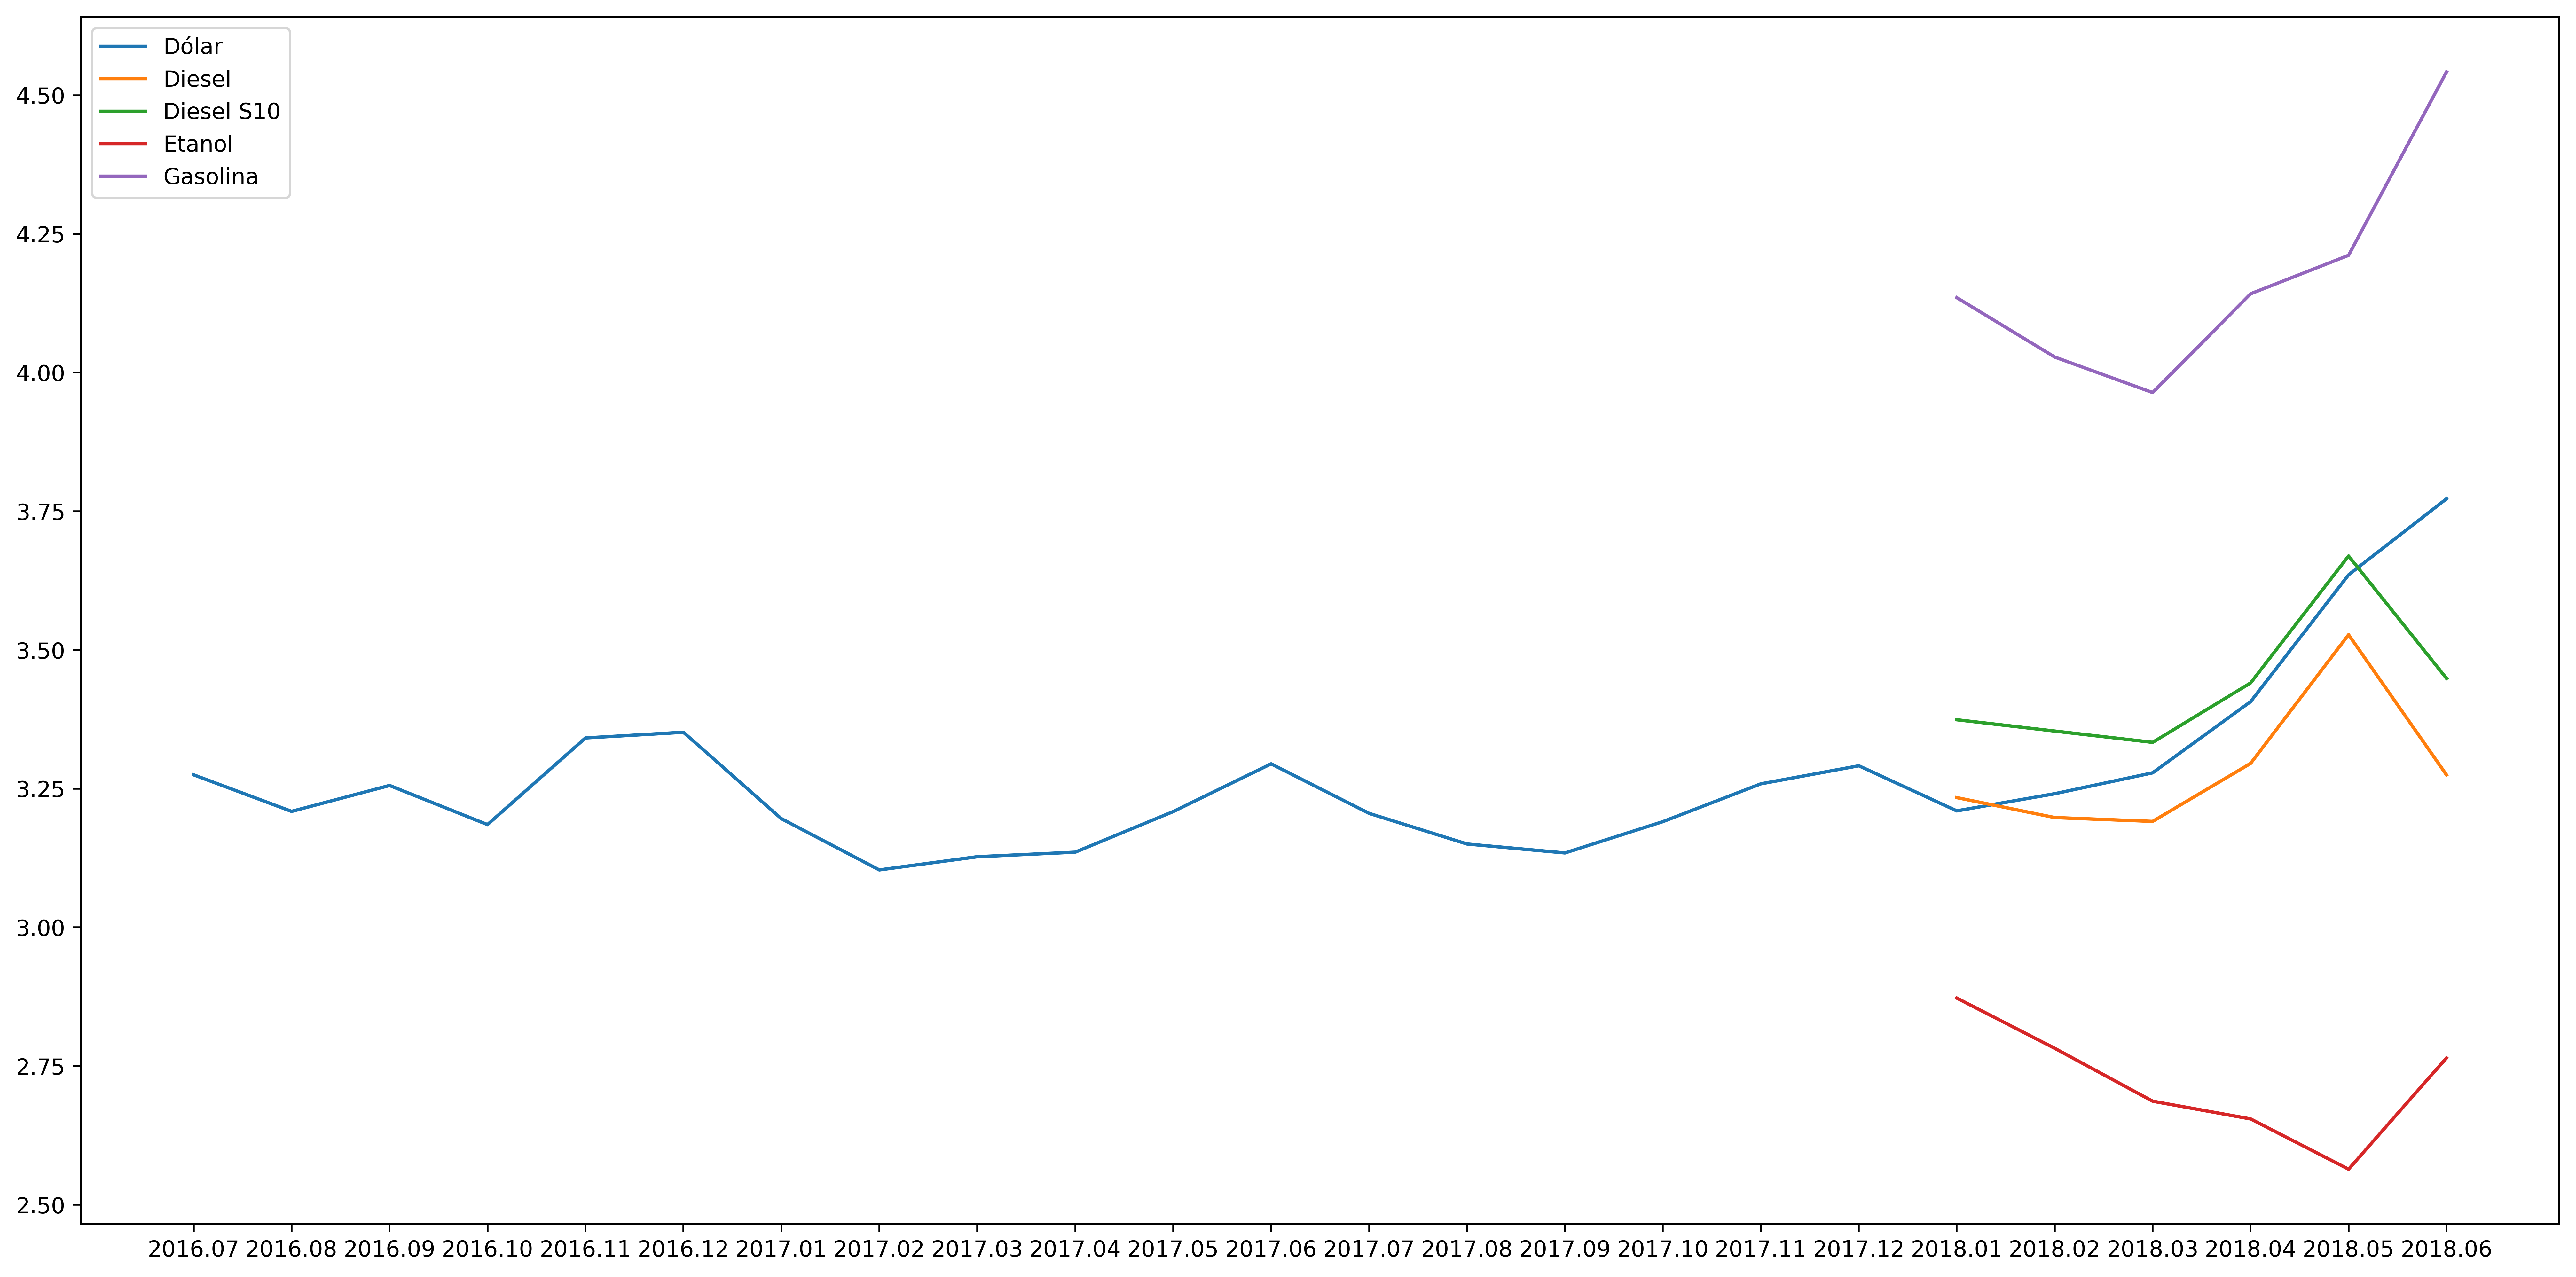

In [25]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 10), dpi=500)

plt.plot(resumo_mes["ano_mes"], resumo_mes["dolar"])
plt.plot(resumo_mes["ano_mes"], resumo_mes["diesel"])
plt.plot(resumo_mes["ano_mes"], resumo_mes["diesel_s10"])
plt.plot(resumo_mes["ano_mes"], resumo_mes["etanol"])
plt.plot(resumo_mes["ano_mes"], resumo_mes["gasolina"])

plt.legend(['Dólar', 'Diesel', 'Diesel S10', 'Etanol', 'Gasolina'])

plt.savefig('evolution.svg', dpi=500)
plt.show()

### Relatório de Máximos e Mínimos

In [24]:
VendasValorDAO = VendasValorCassandra(cassandra_ports, 'gas_price')

municipio = 'SAO JOSE DO RIO PRETO'
produtos = ['GASOLINA', 'ETANOL', 'DIESEL', 'DIESEL S10']

table_var = []

for produto in produtos:
    mais_caro = None
    for venda in VendasValorDAO.get_mais_caros('SAO JOSE DO RIO PRETO', produto, 1):
        mais_caro = venda        

    mais_barato = None
    for venda in VendasValorDAO.get_mais_baratos('SAO JOSE DO RIO PRETO', produto, 1):
        mais_barato = venda

    table_var.append([
        produto,
        round(float(mais_barato.get_valor_venda()), 3),
        mais_barato.get_revenda(),
        mais_barato.get_bandeira(),
        round(float(mais_caro.get_valor_venda()), 3),
        mais_caro.get_revenda(),
        mais_caro.get_bandeira(),
        round((mais_caro.get_valor_venda() - mais_barato.get_valor_venda()) / mais_barato.get_valor_venda() * 100, 3)
    ])

VendasValorDAO.close_connection()

resumo_var = pandas.DataFrame(np.array(table_var), columns=[
    'Produto', 
    'Valor (Menor)', 'Revenda (Menor)', 'Bandeira (Menor)', 
    'Valor (Maior)', 'Revenda (Maior)', 'Bandeira (Maior)', 
    'Variação (%)'
])

from IPython.display import display, HTML
display(HTML(resumo_var.to_html()))

,Produto,Valor (Menor),Revenda (Menor),Bandeira (Menor),Valor (Maior),Revenda (Maior),Bandeira (Maior),Variação (%)
0,GASOLINA,3.699,A P PALACE LTDA,BRANCA,4.719,IRMAOS PORCINI - RIO PRETO LTDA,RAIZEN,27.575
1,ETANOL,2.339,AUTO POSTO ITAMARATI ABUNDÃNCIA LTDA,ALE COMBUSTÃVEIS,2.999,CURVA DA GALINHA AUTO POSTO LTDA,RAIZEN,28.217
2,DIESEL,3.019,AUTO POSTO PACOCAO KM 52 LTDA,RAIZEN,4.027,AUTO POSTO GENERAL LTDA,IPIRANGA,33.389
3,DIESEL S10,3.099,AUTO POSTO M C RIO PRETO LTDA - ME,IPIRANGA,4.277,AUTO POSTO MERCADÃO RIO PRETO LTDA.,IPIRANGA,38.012
